In [1]:
import sys
from pyspark import SparkContext, SparkConf
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy import stats, integrate

In [3]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [5]:
# np.set_printoptions(threshold=np.nan)

### Step1: Collect train data a d lable data

In [4]:
# define the function to get the train data using spark.
def getTrainData(path):
    train_file = sc.textFile(path)
    traindata = train_file.map(lambda line: line.split("\t")).collect()
    X_df = pd.DataFrame(traindata)
    return X_df

In [5]:
# define the function to get the lable data using spark.
def getLableData(path):
    lable_file = sc.textFile(path)
    labeldata = lable_file.map(lambda line: line.split(" ")).collect()
    y_df = pd.DataFrame(labeldata)
    return y_df

In [6]:
# get the large size data and lable
# X_df = getTrainData('/Users/wentingsu/Downloads/final/large_data/orange_large_train.data')

# get the large size data and lable
# y_df = getLableData('/Users/wentingsu/Downloads/final/large_data/orange_large_train_churn.labels.txt')

In [7]:
# get the large size data and lable
X_df = getTrainData('dataset/orange_large_train.data')
y_df = getLableData('dataset/orange_large_train_churn.labels.txt')

### Step2: Processing Missing Data

* 2.1 dealing with String Empty Data

In [9]:
# define the function to process the string empty
def processEmpty(X_df):
    # deal with the string empty 
    X_index = X_df[:1].values.tolist()
    X_df2 = X_df.T.set_index(X_index).T.drop(0)
    X_df3 = X_df2.apply(lambda x: x.str.strip()).replace('', np.nan)
    return X_df3

In [20]:
X_df3 = processEmpty(X_df)

In [21]:
X_df3.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var14991,Var14992,Var14993,Var14994,Var14995,Var14996,Var14997,Var14998,Var14999,Var15000
1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,IPyde4c,NaN,KttQ,NBRvrWWx0Z,NaN,NaN,NaN,NaN
2,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,tQAVcMq,NaN,KttQ,NBRvrWWx0Z,NaN,NaN,NaN,NaN
3,0,0,0,0,6,0,0,0,0,0,...,NaN,NaN,mnKkkvG,NaN,KttQ,NBRvrWWx0Z,NaN,NaN,NaN,NaN
4,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,ZF0bafC,NaN,KttQ,NBRvrWWx0Z,NaN,NaN,NaN,NaN
5,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,z1miBkG,NaN,Q8_a,NaN,NaN,NaN,NaN,NaN


* 2.2 dealing with Numerical Missing Data

In [24]:
# Processing missing data of the numerical columns
def ProcessMissNum(X_df3):
    # extract the numerical colums
    X_num_df = X_df3.ix[:, :14740]
    # drop the columns that all nan
    X_num_df2 = X_num_df.dropna(axis=1, how = 'all')
    # Processing missing numerical data
    X_num = np.array(X_num_df2)
    imputer_num = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
    imputer_num.fit(X_num)
    X_num = imputer_num.transform(X_num)
    return X_num

In [25]:
X_num = ProcessMissNum(X_df3)

In [26]:
pd.DataFrame(X_num).head()

,0,1,2,3,4,5,6,7,8,9,...,14691,14692,14693,14694,14695,14696,14697,14698,14699,14700
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8632.0,22572180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32081400.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8087100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3976080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,34410600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* 2.3 Encoding categorical data

In [27]:
from ipykernel import kernelapp as app

In [28]:
# Encoding categorical data
def ProcessMissCat(X_df3):
    # extract the categorical colums
    X_cat_df = X_df3.ix[:,14740:]
    # drop the columns that all nan
    X_cat_df2 = X_cat_df.dropna(axis=1, how = 'all')
    return X_cat_df2

# call the function
X_cat_df2 = ProcessMissCat(X_df3)

# Encoding categorical data
cols = X_cat_df2.columns
for col in cols:
    X_cat_df2[col] = X_cat_df2[col].astype('category')
X_cat_df2[cols] = X_cat_df2[cols].apply(lambda x: x.cat.codes)

In [29]:
X_cat_df2.head()

,Var14741,Var14742,Var14743,Var14745,Var14746,Var14747,Var14748,Var14749,Var14750,Var14751,...,Var14983,Var14984,Var14989,Var14990,Var14993,Var14995,Var14996,Var14997,Var14998,Var14999
1,0,-1,-1,0,-1,1,-1,-1,-1,-1,...,2,-1,1,0,608,0,0,-1,-1,-1
2,0,-1,-1,-1,8,1,1,-1,-1,-1,...,2,-1,1,12,1893,0,0,-1,-1,-1
3,0,-1,-1,0,-1,1,-1,-1,3,0,...,2,0,1,5,1653,0,0,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,0,1,7,1135,0,0,-1,-1,-1
5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,0,1,0,2047,1,-1,-1,-1,-1


* 2.4 Combine the numerical data and categorical data.

In [30]:
# Comnime the numerical columns and categorical columns
X_df_combine = pd.concat([pd.DataFrame(X_num), pd.DataFrame(np.array(X_cat_df2))], axis=1)

In [31]:
X = X_df_combine.iloc[:, :].values

In [32]:
X_df_combine.head()

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,-1,1,0,608,0,0,-1,-1,-1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,-1,1,12,1893,0,0,-1,-1,-1
2,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,2,0,1,5,1653,0,0,-1,-1,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1,0,1,7,1135,0,0,-1,-1,-1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1,0,1,0,2047,1,-1,-1,-1,-1


* 2.5 Lable Encoding

In [33]:
# deal with the lable y train data 
from sklearn.preprocessing import LabelEncoder

In [34]:
def encodeLable(y_df):
    y = y_df.iloc[:, :].values
    labelencoder_y = LabelEncoder()
    y_train = labelencoder_y.fit_transform(y)
    return y_train

In [36]:
y_train = encodeLable(y_df)[:9999]

//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Step3: Feature Scaling

In [38]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

In [39]:
def featureScal(X):
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X)
    return X_train
X_std = featureScal(X)

In [40]:
X_std

array([[-0.010001  , -0.03052425, -0.03520343, ..., -0.1184263 ,
        -0.36455684, -0.12172848],
       [-0.010001  , -0.03052425, -0.03520343, ..., -0.1184263 ,
        -0.36455684, -0.12172848],
       [-0.010001  , -0.03052425, -0.03520343, ..., -0.1184263 ,
        -0.36455684, -0.12172848],
       ..., 
       [-0.010001  , -0.03052425, -0.03520343, ..., -0.1184263 ,
         1.21855539, -0.12172848],
       [-0.010001  , -0.03052425, -0.03520343, ..., -0.1184263 ,
        -0.36455684, -0.12172848],
       [-0.010001  , -0.03052425, -0.03520343, ..., -0.1184263 ,
        -0.36455684, -0.12172848]])

In [41]:
pd.DataFrame(X_std).head()

,0,1,2,3,4,5,6,7,8,9,...,14880,14881,14882,14883,14884,14885,14886,14887,14888,14889
0,-0.010001,-0.030524,-0.035203,-0.014458,-0.283324,-0.064166,-0.085752,-0.028881,-0.072695,-0.033186,...,1.654065,-1.01888,0.291986,-1.632155,-0.796684,-0.929105,-0.298417,-0.118426,-0.364557,-0.121728
1,-0.010001,-0.030524,-0.035203,-0.014458,-0.283324,-0.064166,-0.085752,-0.028881,-0.072695,-0.033186,...,1.654065,-1.01888,0.291986,0.193237,1.379321,-0.929105,-0.298417,-0.118426,-0.364557,-0.121728
2,-0.010001,-0.030524,-0.035203,-0.014458,3.529533,-0.064166,-0.085752,-0.028881,-0.072695,-0.033186,...,1.654065,0.98147,0.291986,-0.871575,0.972908,-0.929105,-0.298417,-0.118426,-0.364557,-0.121728
3,-0.010001,-0.030524,-0.035203,-0.014458,-0.283324,-0.064166,-0.085752,-0.028881,-0.072695,-0.033186,...,-0.606287,0.98147,0.291986,-0.567343,0.095732,-0.929105,-0.298417,-0.118426,-0.364557,-0.121728
4,-0.010001,-0.030524,-0.035203,-0.014458,-0.283324,-0.064166,-0.085752,-0.028881,-0.072695,-0.033186,...,-0.606287,0.98147,0.291986,-1.632155,1.640103,0.969939,-1.211474,-0.118426,-0.364557,-0.121728


### Step4: PCA

In [42]:
def pcaPlot(X_std):
    # 1 - Eigendecomposition - Computing Eigenvectors and Eigenvalues
    # Covariance Matrix
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
    # 2.
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    #3 sort
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    # plot explained variance ratio
    return var_exp,cum_var_exp

In [43]:
def plotCEV(var_exp,cum_var_exp,n):
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(6, 4))

        plt.bar(range(n), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
        plt.step(range(n), cum_var_exp, where='mid',
             label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

In [44]:
var_exp,cum_var_exp = pcaPlot(X_std)

//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
  self._y = float(xy[1])
//anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


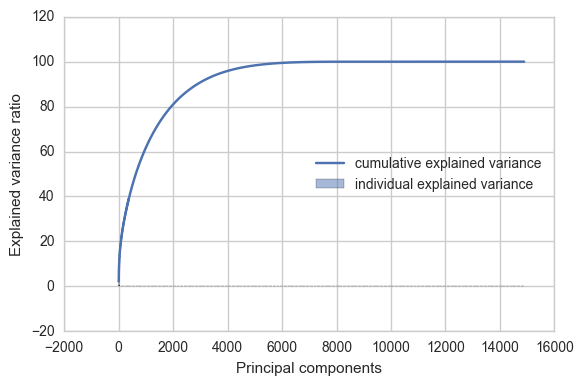

In [47]:
plotCEV(var_exp,cum_var_exp,14890)

//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:643: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
//anaconda/lib/python3.5/site-packages/matplotlib/patches.py:641: ComplexWarning: Casting complex values to real discards the imaginary part
  self._y = float(xy[1])


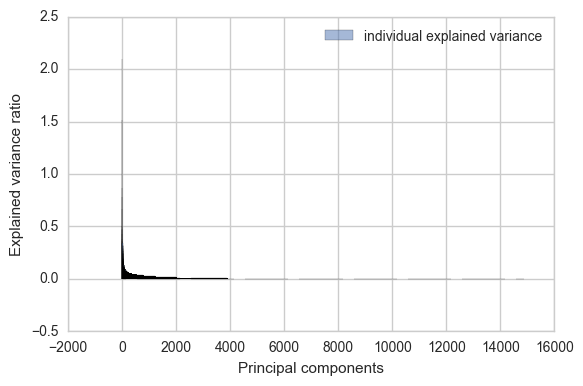

In [50]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(14890), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
#     plt.step(range(212), cum_var_exp, where='mid',
#              label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [ ]:
# Correlation Matrix

In [51]:
from sklearn.decomposition import PCA

In [53]:
def DimReduce(X_std, n):
    X = np.array(X_std)
    pca=PCA(n_components=n)
    pca.fit(X)
    X_Train = DataFrame(pca.transform(X))
    return X_Train

In [54]:
X_Train = DimReduce(X_std, 6000)

In [ ]:
# print(pca.explained_variance_ratio_) 

### Large dataset export

In [56]:
# Export to csv
pd.DataFrame(X_Train).to_csv('dataset/pca_large_train.csv')

In [57]:
# Export to csv
pd.DataFrame(y_train).to_csv('dataset/y_train_large_label.csv')